# Applied Machine Learning Finance

In [73]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier, LinearRegression
from courselib.models.nn import Sigmoid
from courselib.models.nn import MLP
from courselib.models.svm import BinaryKernelSVM
from courselib.models.svm import Kernel, RBFKernel, PolynomialKernel,LinearKernel
from courselib.utils.splits import train_test_split
from courselib.models.base import TrainableModel
from courselib.utils.metrics import binary_accuracy, mean_squared_error, mean_absolute_error,accuracy
from courselib.optimizers import GDOptimizer
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier
from courselib.utils.normalization import min_max
from courselib.models.glm import LogisticRegression,sigmoid
from courselib.models.base import TrainableModel
from courselib.utils.preprocessing import labels_encoding
from courselib.models.svm import LinearSVM
from courselib.models.svm import BinaryKernelSVM
from courselib.utils.metrics import cross_entropy
from courselib.utils.normalization import standardize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Functions

In [74]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    df = pd.DataFrame(data)
    df.columns = df.columns.droplevel(1)
    return df



def compute_technical_indicators(data,amount,window):
    df = data.copy()

    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()

    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()

    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0).abs()
    avg_gain = up.ewm(window, adjust=False).mean()
    avg_loss = down.ewm(window, adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}'] = 100 - (100 / (1 + rs))

    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std

    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Daily_Return'] = df['Close'].pct_change()


    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()

    for i in range(amount):
        df[f'Lag_{i+1}'] = df['Daily_Return'].shift(i)

    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

def return_data(df, target_type='Target_01', train_frac=0.8,features='whole'):
    df['Trend'] = df['Close'].rolling(window=5).mean().shift(-1) > df['Close']
    df['Target_01'] = np.where(df['Trend'], 1, 0)
    df['Target_-1'] = np.where(df['Trend'], 1, -1)
    df = compute_technical_indicators(df, 3, 14)

    whole = ['SMA_14', 'EMA_14', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower',
                'MACD', 'MACD_Signal', 'Daily_Return', 'Rolling_5d_Std',
                'Lag_1', 'Lag_2', 'Lag_3', 'Momentum_10', target_type, 'Close']
    
    correlation = ['Lag_2','Momentum_10','RSI_14','Lag_1',target_type,'Daily_Return']
    
    relevance = ['Daily_Return','Lag_1','RSI_14','Momentum_10',target_type,'Lag_2']
    
    lagged = ['Lag_1', 'Lag_2', 'Lag_3', target_type]
    
    if features == 'whole':
        features = whole
    elif features == 'correlation':
        features = correlation
    elif features == 'relevance':
        features = relevance
    elif features == 'lagged':
        features = lagged
    else:
        assert isinstance(features, list), "`features` must be 'whole' or a list of feature names."

    df = df[features]
    df = df.reset_index()
    df.dropna(inplace=True)

    X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df.iloc[:, df.columns != 'Date'],
                                                              training_data_fraction=train_frac,
                                                              return_numpy=True,
                                                              shuffle=False,
                                                              class_column_name=target_type)
    return X, Y, X_train, Y_train, X_test, Y_test



In [75]:
def return_data_daily_return(df, target_type='Target_01', train_frac=0.8,features='whole'):
    df['Target_Sign'] = np.sign(df['Close'].shift(-1) - df['Close']).shift(-1)
    df['Target_Sign_01'] = df['Target_Sign'].where(df['Target_Sign'].isna(),np.where(df['Target_Sign'] > 0, 1, 0))    
    df = compute_technical_indicators(df, 3, 14)

    whole = ['SMA_14', 'EMA_14', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower',
                'MACD', 'MACD_Signal', 'Daily_Return', 'Rolling_5d_Std',
                'Lag_1', 'Lag_2', 'Lag_3', 'Momentum_10', target_type, 'Close']
    
    correlation = ['Lag_2','Momentum_10','RSI_14','Lag_1',target_type,'Daily_Return']
    
    relevance = ['Daily_Return','Lag_1','RSI_14','Momentum_10',target_type,'Lag_2']
    
    lagged = ['Lag_1', 'Lag_2', 'Lag_3', target_type]
    
    if features == 'whole':
        features = whole
    elif features == 'correlation':
        features = correlation
    elif features == 'relevance':
        features = relevance
    elif features == 'lagged':
        features = lagged
    else:
        assert isinstance(features, list), "`features` must be 'whole' or a list of feature names."

    df = df[features]
    df = df.reset_index()
    df.dropna(inplace=True)

    X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df.iloc[:, df.columns != 'Date'],
                                                              training_data_fraction=train_frac,
                                                              return_numpy=True,
                                                              shuffle=False,
                                                              class_column_name=target_type)
    return X, Y, X_train, Y_train, X_test, Y_test, df


In [77]:
class LogisticRegressionLasso(TrainableModel):
    """
    Binary logistic regression model.

    Parameters:
        - w: Initial weights (array-like)
        - b: Initial bias (scalar)
        - optimizer: Optimizer object (e.g., GDOptimizer)
    """
    
    def __init__(self, w, b, optimizer,lam):
        super().__init__(optimizer)
        self.w = np.array(w, dtype=float)
        self.b = np.array(b, dtype=float)
        self.lam = lam

    def loss_grad(self, X, y):
        residual = self.decision_function(X) - y
        grad_w = X.T @ residual / len(X) + self.lam*np.sign(self.w)
        grad_b = np.mean(residual)
        return {"w": grad_w, "b": grad_b}
    
    def decision_function(self, X):
        return sigmoid(X @ self.w + self.b)
    
    def _get_params(self):
        """
        Return model parameters as a dict for the optimizer.
        """
        return {"w": self.w, "b": self.b}

    def __call__(self, X):
        return np.where(self.decision_function(X) >= 0.5, 1, 0)

## Model testing and Analysis


In [78]:
df = fetch_data('SPY', '2015-01-01', '2023-12-31')
df

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_2054/1762355872.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,171.568069,172.779070,170.524112,172.361487,121465900
2015-01-05,168.469574,170.682757,168.160567,170.515727,169632600
2015-01-06,166.882736,169.304710,166.080972,168.778552,209151400
2015-01-07,168.962311,169.304732,167.768030,168.219014,125346700
2015-01-08,171.960587,172.177738,170.365430,170.382124,147217800
...,...,...,...,...,...
2023-12-22,464.874420,466.572378,462.960567,465.080521,67126600
2023-12-26,466.837372,467.750134,465.208124,465.286659,55387000
2023-12-27,467.681427,467.828642,466.091446,466.631244,68000300


In [79]:
X_01, Y_01, X_01_train, Y_01_train, X_01_test, Y_01_test = return_data(df, target_type='Target_01', train_frac=0.8, features='whole')
X_01 = min_max(X_01)
X_01_train = min_max(X_01_train)
X_01_test = min_max(X_01_test)
X_1, Y_1, X_1_train, Y_1_train, X_1_test, Y_1_test = return_data(df, target_type='Target_-1', train_frac=0.8, features='whole')
X_1 = min_max(X_1)
X_1_train = min_max(X_1_train)
X_1_test = min_max(X_1_test)
Y_ec, Y_ec_train, Y_ec_test = labels_encoding(Y_1), labels_encoding(Y_1_train), labels_encoding(Y_1_test)

### Logistic Regression

In [81]:
# Model setup
w = [0] * X_01.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-1)

accuracy_regression = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict = {'accuracy': accuracy_regression, 'MSE': mean_squared_error}

model_regression = LogisticRegressionLasso(w, b, optimizer,1e-5)

# Train the model
metrics_history_regression = model_regression.fit(
    X_01_train, Y_01_train,
    num_epochs=20000,
    batch_size=len(X_01_train),
    compute_metrics=True,
    metrics_dict=metrics_dict
)


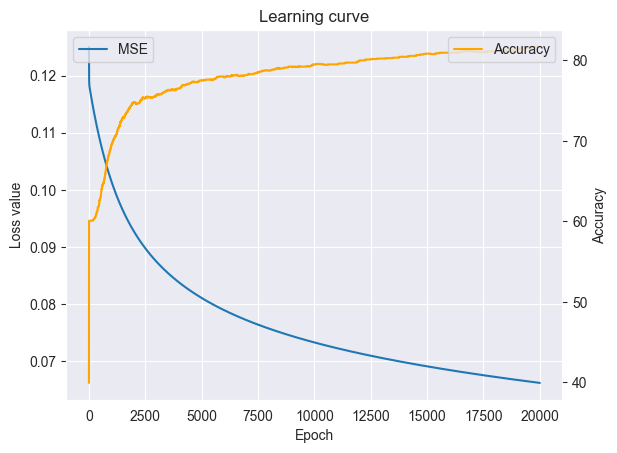

The final train accuracy: 81.68%
Test accuracy: 85.52%


In [91]:
# Plot learning curve
fig, ax = plt.subplots()
ax.plot(range(len(metrics_history_regression['MSE'])), metrics_history_regression['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax2 = ax.twinx()
ax2.plot(range(len(metrics_history_regression['accuracy'])), metrics_history_regression['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.title('Learning curve')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()
plt.show()

# Evaluation
print(f'The final train accuracy: {metrics_history_regression["accuracy"][-1]:.2f}%')
print(f'Test accuracy: {accuracy_regression(model_regression.decision_function(X_01_test), Y_01_test):.2f}%')

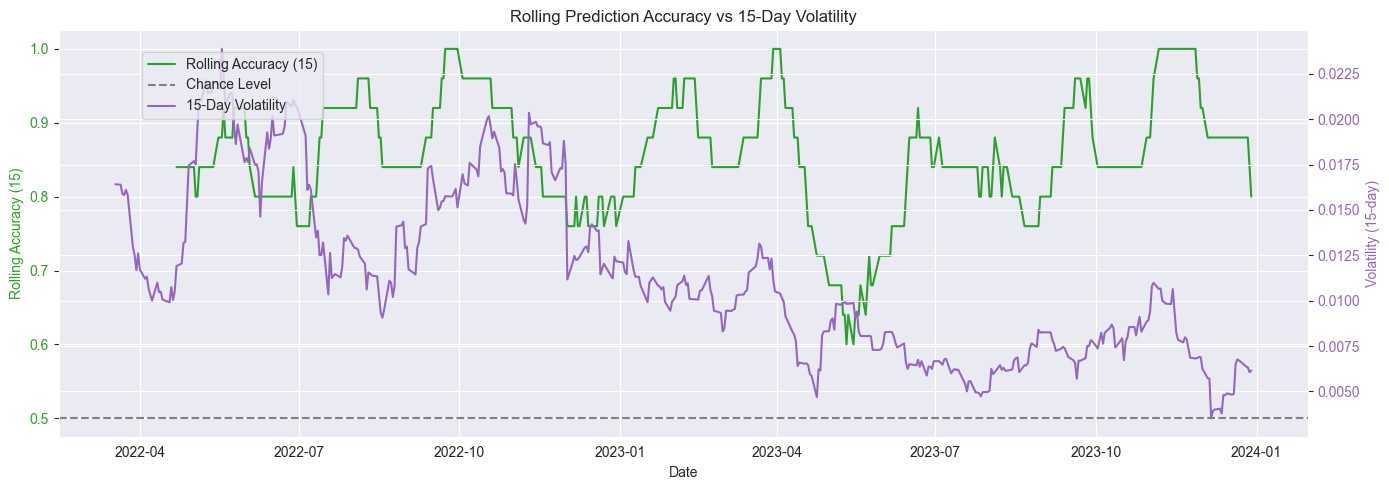

In [92]:
# Ensure Date column exists
if 'Date' not in df.columns and df.index.name == 'Date':
    df = df.reset_index()

# Prepare indicators and labels
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index(drop=True)
df_copy.dropna(inplace=True)

# Align dates with model input
date_series = df_copy['Date'].iloc[-len(X_01):].values
split_idx = int(len(X_01) * 0.8)
test_dates = date_series[split_idx:]

# Model predictions
Y_pred = model_regression(X_01_test)
Y_pred_labels = (Y_pred > 0.5).astype(int).flatten()
Y_true_labels = Y_01_test.flatten()

# Accuracy computation
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_labels,
    'Predicted': Y_pred_labels
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=25).mean()

# Volatility computation
df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=15).std()
vol_series = df_copy['Volatility_15d'].iloc[-len(X_01):].values
vol_test = vol_series[split_idx:]

# --- Combined Plot ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot Rolling Accuracy
color1 = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Accuracy (15)', color=color1)
ax1.plot(test_dates, results_df['Rolling_Accuracy'], color=color1, label='Rolling Accuracy (15)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis
ax2 = ax1.twinx()
color2 = 'tab:purple'
ax2.set_ylabel('Volatility (15-day)', color=color2)
ax2.plot(test_dates, vol_test, color=color2, label='15-Day Volatility')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Rolling Prediction Accuracy vs 15-Day Volatility')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

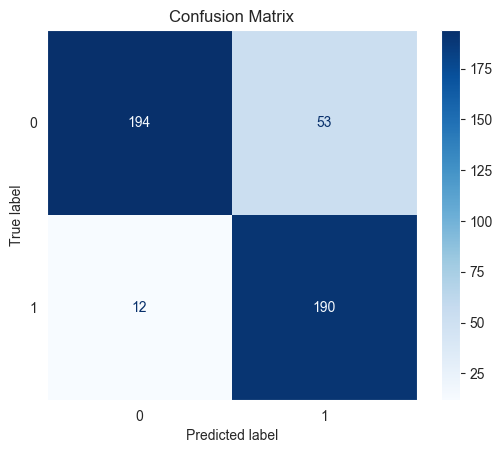

In [93]:
y_pred = model_regression(X_01_test)
# Compute confusion matrix
cm = confusion_matrix(Y_01_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Kernel SVM

In [94]:
kernels = ['linear', 'polynomial', 'rbf']
for i in range(10):
    start = time.time()
    svm_poly = BinaryKernelSVM(kernel='polynomial', degree=i)
    svm_poly.fit(X_1_train, Y_1_train)
    end = time.time()

    test_acc = binary_accuracy(svm_poly(X_1_test), Y_1_test)

    train_acc = binary_accuracy(svm_poly(X_1_train), Y_1_train)

    print(f'Test accuracy degree {i}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

    train_time = end - start

    print(f"⏱️ Train time: {train_time:.4f} seconds")

sigma_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
for i in sigma_values:
    start = time.time()
    svm_rbf_values = BinaryKernelSVM(kernel='rbf', sigma=i)
    svm_rbf_values.fit(X_1_train, Y_1_train)
    end = time.time()

    test_acc = binary_accuracy(svm_rbf_values(X_1_test), Y_1_test)

    train_acc = binary_accuracy(svm_rbf_values(X_1_train), Y_1_train)

    print(f'Test accuracy sigma {i}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

    train_time = end - start

    print(f"⏱️ Train time: {train_time:.4f} seconds")


Test accuracy degree 0: 55.0111, Train accuracy: 60.0780
⏱️ Train time: 6.0907 seconds


KeyboardInterrupt: 

Test accuracy sigma 1: 74.3875, Train accuracy: 82.9621


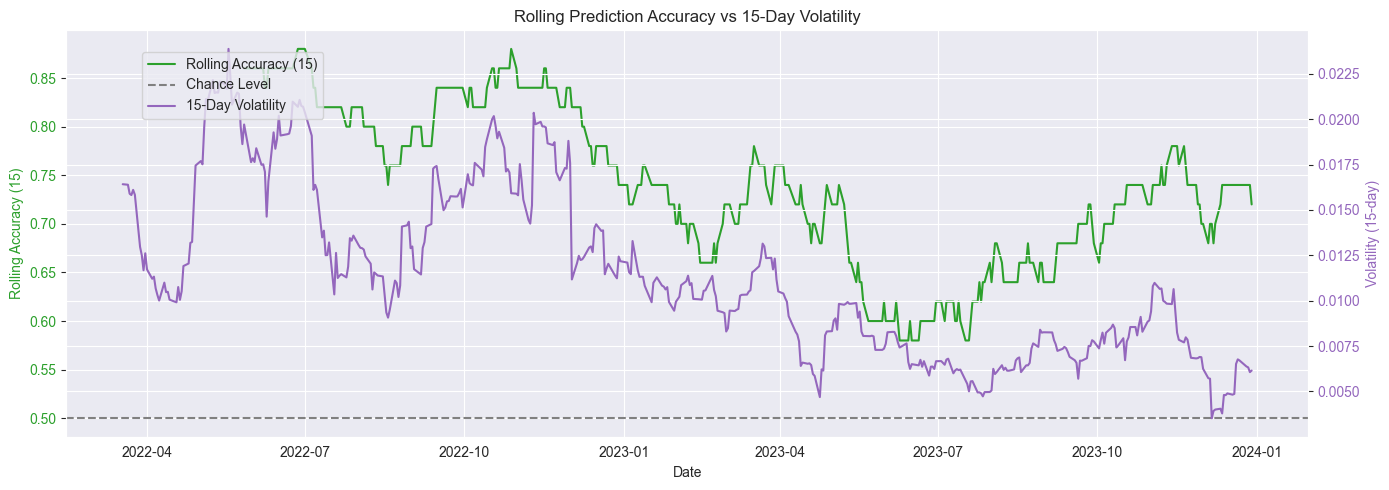

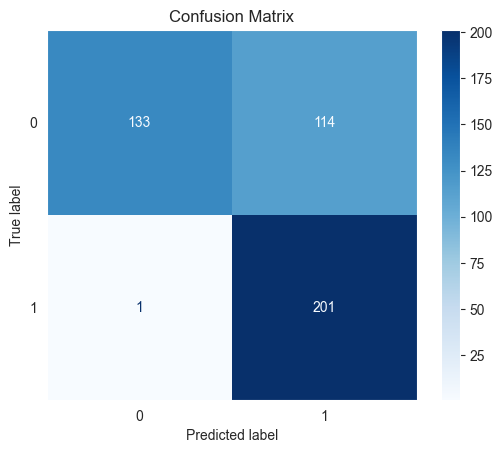

In [95]:
# Train model
svm_rbf = BinaryKernelSVM(kernel='rbf', sigma=1)
svm_rbf.fit(X_1_train, Y_1_train)

# Evaluate
test_acc = binary_accuracy(svm_rbf(X_1_test), Y_1_test)
train_acc = binary_accuracy(svm_rbf(X_1_train), Y_1_train)

print(f'Test accuracy sigma {1}: {test_acc:.4f}, Train accuracy: {train_acc:.4f}')

# --- Rolling accuracy visualization ---

# Get the corresponding dates from the original df
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index()  # Ensure 'Date' is a column
df_copy.dropna(inplace=True)

# Align dates with final feature set
date_series = df_copy['Date'].iloc[-len(X_1):].values
split_idx = int(len(X_1) * 0.8)
test_dates = date_series[split_idx:]

# Predictions
Y_pred = svm_rbf(X_1_test)
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_1_test,
    'Predicted': Y_pred
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# Volatility computation
df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=15).std()
vol_series = df_copy['Volatility_15d'].iloc[-len(X_1):].values
vol_test = vol_series[split_idx:]

# --- Combined Plot ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot Rolling Accuracy
color1 = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Accuracy (15)', color=color1)
ax1.plot(test_dates, results_df['Rolling_Accuracy'], color=color1, label='Rolling Accuracy (15)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis
ax2 = ax1.twinx()
color2 = 'tab:purple'
ax2.set_ylabel('Volatility (15-day)', color=color2)
ax2.plot(test_dates, vol_test, color=color2, label='15-Day Volatility')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Rolling Prediction Accuracy vs 15-Day Volatility')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Compute confusion matrix
cm = confusion_matrix(Y_1_test, Y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


### Neural Network

In [99]:
metrics_dict = {
    "accuracy": accuracy,
    "loss": mean_squared_error
}


optimizer = GDOptimizer(learning_rate=1)

model_nn = MLP(widths=[14, 64,32, 2], optimizer=optimizer, activation='ReLU', output_activation='Linear', loss='MSE')

metrics_history_nn = model_nn.fit(X_1_train, Y_ec_train, num_epochs=15000, batch_size=len(X_1_train), compute_metrics=True,
                            metrics_dict=metrics_dict)




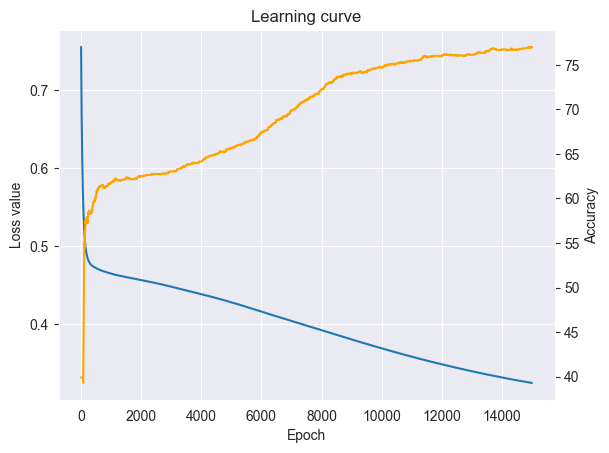

The final train accuracy: 77.0%
Test accuracy: 83.1%


In [113]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history_nn['loss'])), metrics_history_nn['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history_nn['accuracy'])), metrics_history_nn['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()
plt.show()

print(f'The final train accuracy: {round(metrics_history_nn["accuracy"][-1], 1)}%')
print(f'Test accuracy: {round(accuracy(model_nn.decision_function(X_1_test), Y_ec_test), 1)}%')



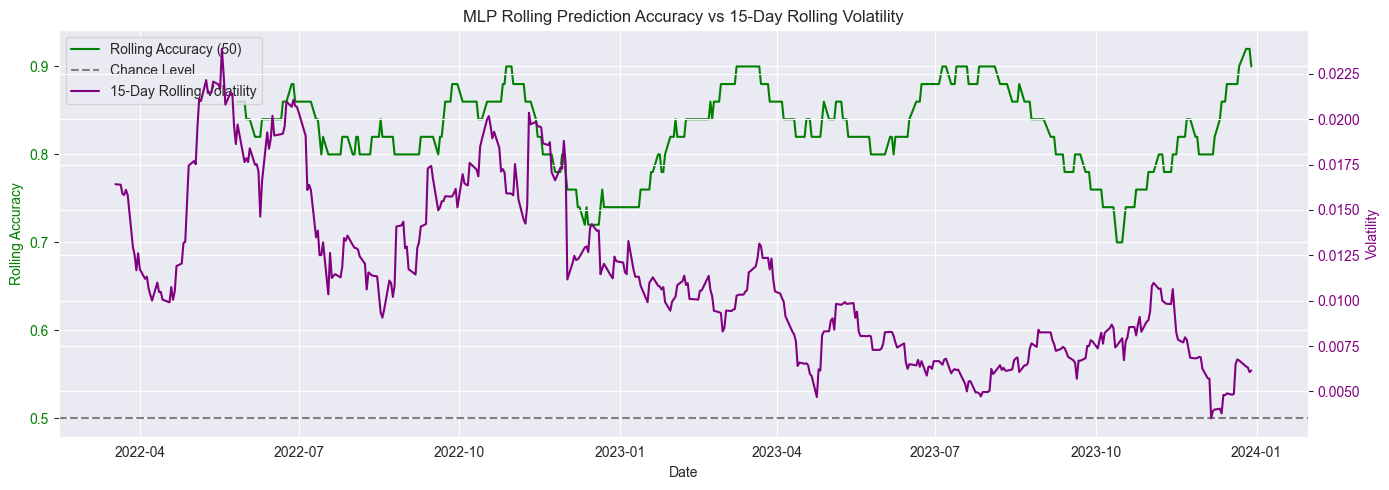

In [101]:
Y_pred = model_nn(X_1_test)

# Convert predictions to class labels
if Y_pred.ndim == 1 or Y_pred.shape[1] == 1:
    Y_pred_labels = (Y_pred > 0).astype(int).flatten()
    Y_true_labels = Y_ec_test.flatten() if Y_ec_test.ndim == 1 else Y_ec_test.argmax(axis=1)
else:
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(Y_ec_test, axis=1)

# --- Rebuild full dataframe with technical indicators ---
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)


df_copy = compute_technical_indicators(df_copy, 3, 14)

df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

# --- Build Accuracy DataFrame ---
test_dates = df_copy['Date'].iloc[-len(X_1_test):].values
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_labels,
    'Predicted': Y_pred_labels
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# --- Calculate Volatility ---
df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=15).std()

# Align with test set
vol_series = df_copy['Volatility_15d'].iloc[-len(X_1):].values
date_series = df_copy['Date'].iloc[-len(X_1):].values
split_idx = int(len(X_1) * 0.8)
vol_test = vol_series[split_idx:]
vol_dates = date_series[split_idx:]

# --- Combined Plot ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# Accuracy
ax1.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.set_ylabel('Rolling Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Volatility
ax2 = ax1.twinx()
ax2.plot(vol_dates, vol_test, color='purple', label='15-Day Rolling Volatility')
ax2.set_ylabel('Volatility', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Title and axes
plt.title('MLP Rolling Prediction Accuracy vs 15-Day Rolling Volatility')
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()


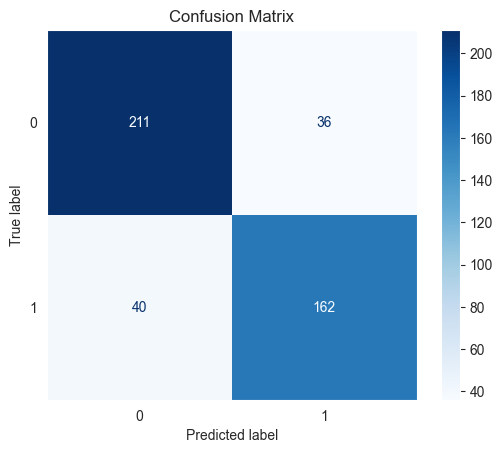

In [102]:
Y_pred = model_nn(X_1_test)
# Convert predicted outputs to class labels
if Y_pred.ndim == 1 or Y_pred.shape[1] == 1:
    Y_pred_labels = (Y_pred > 0).astype(int).flatten()
    Y_true_labels = Y_ec_test.flatten() if Y_ec_test.ndim == 1 else Y_ec_test.argmax(axis=1)
else:
    # Multiclass (e.g. shape [n_samples, 2])
    Y_pred_labels = np.argmax(Y_pred, axis=1)
    Y_true_labels = np.argmax(Y_ec_test, axis=1)
# Compute and display the confusion matrix
cm = confusion_matrix(Y_true_labels, Y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Baseline Model using autoregressive model and lagged returns

In [103]:
X_lag, Y_lag, X_lag_train, Y_lag_train, X_lag_test, Y_lag_test = return_data(df,target_type='Target_01',train_frac=.8,features = 'lagged')
X_lag = min_max(X_lag)
X_lag_train = min_max(X_lag_train)
X_lag_test = min_max(X_lag_test)
w = [0] * X_lag.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-2)

accuracy_lag = lambda y_true, y_pred: binary_accuracy(y_true, y_pred, class_labels=[0, 1])
metrics_dict = {'accuracy': accuracy_lag, 'MSE': mean_squared_error}

model_lag = LinearRegression(w, b, optimizer)

metrics_history_lag = model_lag.fit(
    X_lag_train, Y_lag_train,
    num_epochs=20000,
    batch_size=len(X_lag_train),
    compute_metrics=True,
    metrics_dict=metrics_dict
)


Final train accuracy (baseline): 67.00%
Test accuracy (baseline): 71.68%


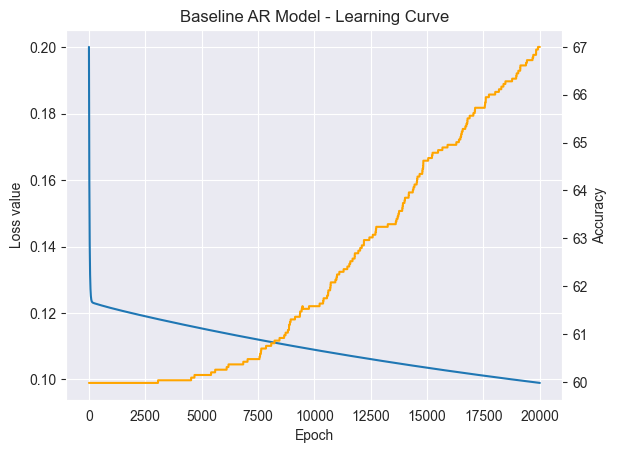

In [104]:
# Plot metrics

fig, ax = plt.subplots()
ax.plot(metrics_history_lag['MSE'], label='MSE')
ax.set_ylabel('Loss value')
ax.set_xlabel('Epoch')
ax2 = ax.twinx()
ax2.plot(metrics_history_lag['accuracy'], color='orange', label='Accuracy')
ax2.set_ylabel('Accuracy')
plt.title('Baseline AR Model - Learning Curve')
plt.grid()

# Final metrics
train_acc = metrics_history_lag["accuracy"][-1]
test_acc = accuracy_lag(model_lag.decision_function(X_lag_test), Y_lag_test)

print(f'Final train accuracy (baseline): {train_acc :.2f}%')
print(f'Test accuracy (baseline): {test_acc :.2f}%')

plt.show()

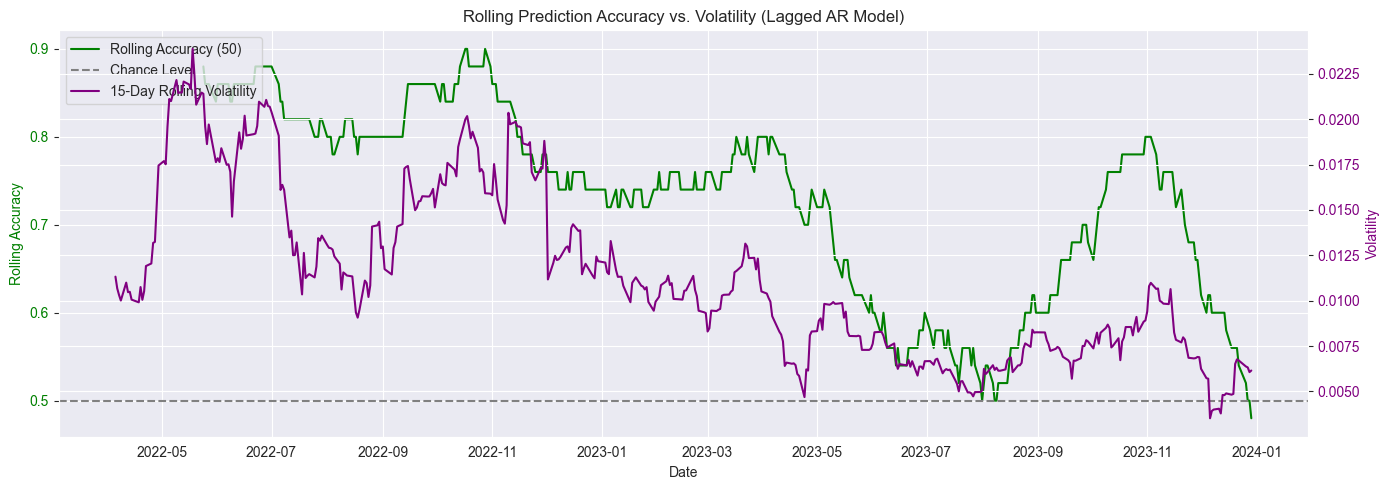

In [105]:
# --- Preprocess Y ---
Y_true = Y_lag_test.flatten() if Y_lag_test.ndim > 1 else Y_lag_test
Y_pred_raw = model_lag(X_lag_test)
Y_pred = (Y_pred_raw > 0.5).astype(int).flatten()

# --- Prepare df_copy with indicators and trend ---
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)


df_copy = compute_technical_indicators(df_copy, 3, 14)

df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

# --- Build accuracy DataFrame ---
test_dates = df_copy['Date'].iloc[-len(X_lag_test):].values
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true,
    'Predicted': Y_pred
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# --- Compute volatility ---
df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=15).std()

# Align volatility to X_full and test period
vol_series = df_copy['Volatility_15d'].iloc[-len(X_lag):].values
date_series = df_copy['Date'].iloc[-len(X_lag):].values
split_idx = int(len(X_lag) * 0.8)
vol_test = vol_series[split_idx:]
vol_dates = date_series[split_idx:]

# --- Combined Plot: Accuracy + Volatility ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# Rolling Accuracy
ax1.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.set_ylabel('Rolling Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Volatility (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(vol_dates, vol_test, color='purple', label='15-Day Rolling Volatility')
ax2.set_ylabel('Volatility', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Labels and legend
plt.title('Rolling Prediction Accuracy vs. Volatility (Lagged AR Model)')
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()


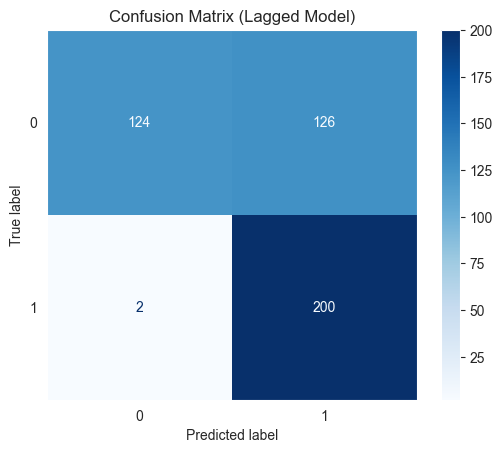

In [106]:
# Get raw predictions (continuous values)
y_pred_raw = model_lag(X_lag_test)

# Convert raw predictions to binary class labels by thresholding at 0.5
y_pred_labels = (y_pred_raw > 0.5).astype(int).flatten()

# Flatten true labels if needed
y_true = Y_lag_test.flatten() if Y_lag_test.ndim > 1 else Y_lag_test

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Lagged Model)')
plt.grid(False)
plt.show()

## Transferability 

Neural Network


In [107]:
df_transferability = fetch_data('AMZN', '2015-01-01', '2023-12-31')
X_1_transfer, Y_1_transfer, X_1_train_transfer, Y_1_train_transfer, X_1_test_transfer, Y_1_test_transfer = return_data(df_transferability,target_type='Target_-1',train_frac=.8)
X_1_transfer = min_max(X_1_transfer)
X_1_train_transfer = min_max(X_1_train_transfer)
X_1_test_transfer = min_max(X_1_test_transfer)
Y_1_transfer, Y_1_train_transfer, Y_1_test_transfer = labels_encoding(Y_1_transfer), labels_encoding(Y_1_train_transfer), labels_encoding(Y_1_test_transfer)

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_2054/1762355872.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [108]:
print(f'The final train accuracy: {round(metrics_history_nn["accuracy"][-1], 1)}%')
print(f'Test accuracy: {round(accuracy(model_nn.decision_function(X_1_test_transfer), Y_1_test_transfer), 1)}%')

The final train accuracy: 77.0%
Test accuracy: 72.6%


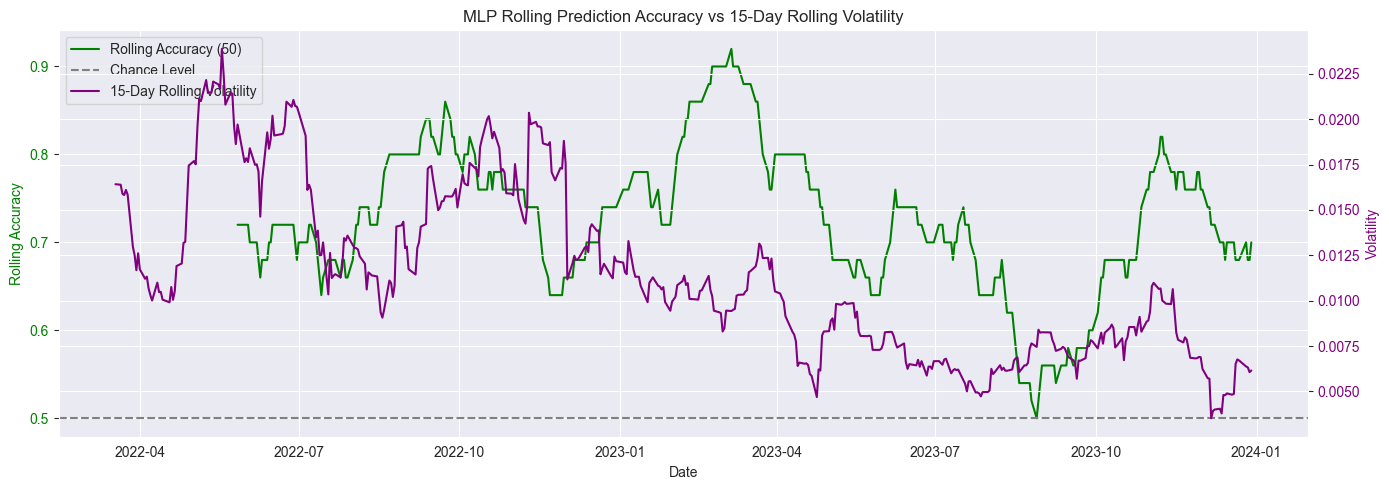

In [109]:
Y_pred_transfer = model_nn(X_1_test_transfer)

# Convert predictions to class labels
if Y_pred_transfer.ndim == 1 or Y_pred_transfer.shape[1] == 1:
    Y_pred_transfer_labels = (Y_pred_transfer > 0).astype(int).flatten()
    Y_true_transfer_labels = Y_1_test_transfer.flatten() if Y_1_test_transfer.ndim == 1 else Y_1_test_transfer.argmax(axis=1)
else:
    Y_pred_transfer_labels = np.argmax(Y_pred_transfer, axis=1)
    Y_true_transfer_labels = np.argmax(Y_1_test_transfer, axis=1)

# --- Rebuild full dataframe with technical indicators ---
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)


df_copy = compute_technical_indicators(df_copy, 3, 14)

df_copy = df_copy.reset_index()
df_copy.dropna(inplace=True)

# --- Build Accuracy DataFrame ---
test_dates = df_copy['Date'].iloc[-len(X_1_test_transfer):].values
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_transfer_labels,
    'Predicted': Y_pred_transfer_labels
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=50).mean()

# --- Calculate Volatility ---
df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=15).std()

# Align with test set
vol_series = df_copy['Volatility_15d'].iloc[-len(X_1_transfer):].values
date_series = df_copy['Date'].iloc[-len(X_1_transfer):].values
split_idx = int(len(X_1_transfer) * 0.8)
vol_test = vol_series[split_idx:]
vol_dates = date_series[split_idx:]

# --- Combined Plot ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# Accuracy
ax1.plot(results_df['Date'], results_df['Rolling_Accuracy'], color='green', label='Rolling Accuracy (50)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.set_ylabel('Rolling Accuracy', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Volatility
ax2 = ax1.twinx()
ax2.plot(vol_dates, vol_test, color='purple', label='15-Day Rolling Volatility')
ax2.set_ylabel('Volatility', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Title and axes
plt.title('MLP Rolling Prediction Accuracy vs 15-Day Rolling Volatility')
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.grid(True)
fig.tight_layout()

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

Logistic Regression

In [110]:
df_transferability = fetch_data('AMZN', '2015-01-01', '2023-12-31')
X_01_transfer, Y_01_transfer, X_01_train_transfer, Y_01_train_transfer, X_01_test_transfer, Y_01_test_transfer = return_data(df_transferability,target_type='Target_01',train_frac=.8)
X_01_transfer = min_max(X_01_transfer)
X_01_train_transfer = min_max(X_01_train_transfer)
X_01_test_transfer = min_max(X_01_test_transfer)


/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_2054/1762355872.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [111]:
print(f'The final train accuracy: {metrics_history_lag["accuracy"][-1]:.2f}%')
print(f'Test accuracy: {accuracy_regression(model_regression.decision_function(X_01_test_transfer), Y_01_test_transfer):.2f}%')

The final train accuracy: 67.00%
Test accuracy: 76.39%


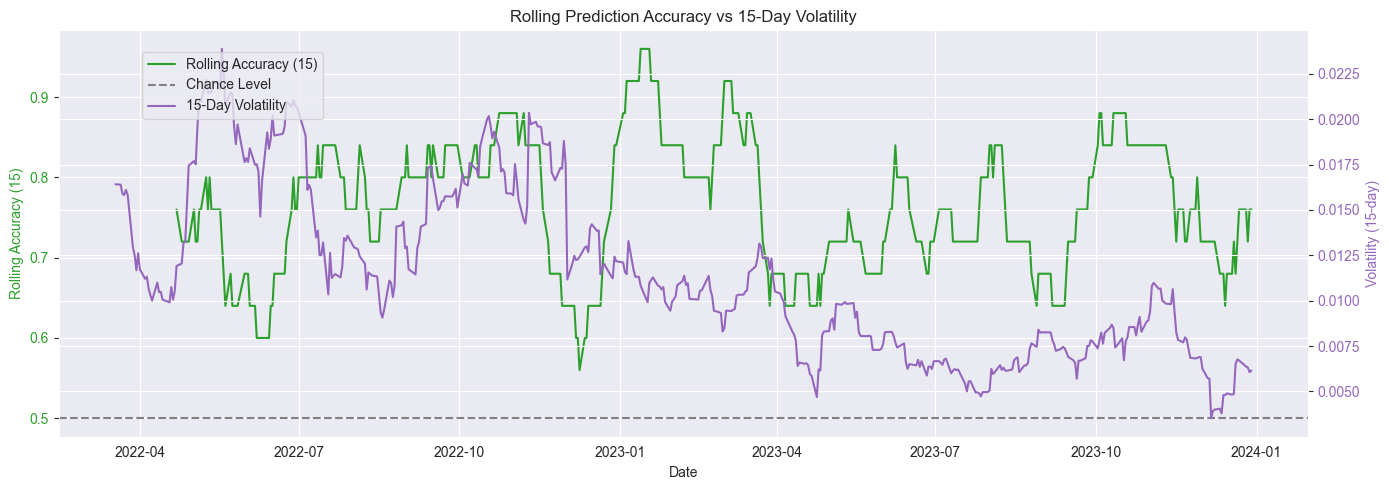

In [112]:
# Ensure Date column exists
if 'Date' not in df.columns and df.index.name == 'Date':
    df = df.reset_index()

# Prepare indicators and labels
df_copy = df.copy()
df_copy['Trend'] = df_copy['Close'].rolling(window=5).mean().shift(-1) > df_copy['Close']
df_copy['Target_01'] = np.where(df_copy['Trend'], 1, 0)
df_copy['Target_-1'] = np.where(df_copy['Trend'], 1, -1)
df_copy = compute_technical_indicators(df_copy, 3, 14)
df_copy = df_copy.reset_index(drop=True)
df_copy.dropna(inplace=True)

# Align dates with model input
date_series = df_copy['Date'].iloc[-len(X_01_transfer):].values
split_idx = int(len(X_01_transfer) * 0.8)
test_dates = date_series[split_idx:]

# Model predictions
Y_pred_transfer = model_regression(X_01_test_transfer)
Y_pred_labels = (Y_pred_transfer > 0.5).astype(int).flatten()
Y_true_labels = Y_01_test_transfer.flatten()

# Accuracy computation
results_df = pd.DataFrame({
    'Date': test_dates,
    'True': Y_true_labels,
    'Predicted': Y_pred_labels
})
results_df['Correct'] = results_df['True'] == results_df['Predicted']
results_df['Rolling_Accuracy'] = results_df['Correct'].rolling(window=25).mean()

# Volatility computation
df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy['Volatility_15d'] = df_copy['Daily_Return'].rolling(window=15).std()
vol_series = df_copy['Volatility_15d'].iloc[-len(X_01_transfer):].values
vol_test = vol_series[split_idx:]

# --- Combined Plot ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# Plot Rolling Accuracy
color1 = 'tab:green'
ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Accuracy (15)', color=color1)
ax1.plot(test_dates, results_df['Rolling_Accuracy'], color=color1, label='Rolling Accuracy (15)')
ax1.axhline(0.5, color='gray', linestyle='--', label='Chance Level')
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis
ax2 = ax1.twinx()
color2 = 'tab:purple'
ax2.set_ylabel('Volatility (15-day)', color=color2)
ax2.plot(test_dates, vol_test, color=color2, label='15-Day Volatility')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Rolling Prediction Accuracy vs 15-Day Volatility')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Daily Return Analysis and Trading Strategies

## RBF SVM

Model Training

In [25]:
data = fetch_data('SPY', '2015-01-01', '2025-07-12')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, data = return_data_daily_return(data, target_type='Target_Sign', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)


/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_838/1762355872.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [26]:
rbf_svm = BinaryKernelSVM(kernel='rbf',sigma = 1.0)
metrics_history = rbf_svm.fit(X_train,Y_train)
binary_acc = binary_accuracy(rbf_svm(X_train), Y_train)

In [27]:
y_pred_test = rbf_svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)

Test Accuracy: 55.42857142857143


Trading Strategy with RBF SVM

In [28]:
split_idx = int(round(train_frac * len(data)))
test_indices = data.index[split_idx:]

data['rbf_svm_pred'] = np.nan
data.loc[test_indices, 'rbf_svm_pred'] = y_pred_test
data['rbf_svm_pred'] = data['rbf_svm_pred'].shift(1)
data.dropna(inplace=True)
print("Number of -1 predictions:", (data['rbf_svm_pred'] == -1).sum())
print("Number of 1 predictions:", (data['rbf_svm_pred'] == 1).sum())

Number of -1 predictions: 189
Number of 1 predictions: 335


In [29]:
data['strategy_return'] = data['Daily_Return'] * data['rbf_svm_pred']
data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
data['cumulative_asset'] = (1 + data['Daily_Return']).cumprod()
print("strategy return is", round(data['cumulative_strategy'].iloc[-1]-1,4)*100, "%")
print("asset return is", round(data['cumulative_asset'].iloc[-1]-1,4)*100, "%")

strategy return is 40.760000000000005 %
asset return is 50.56 %


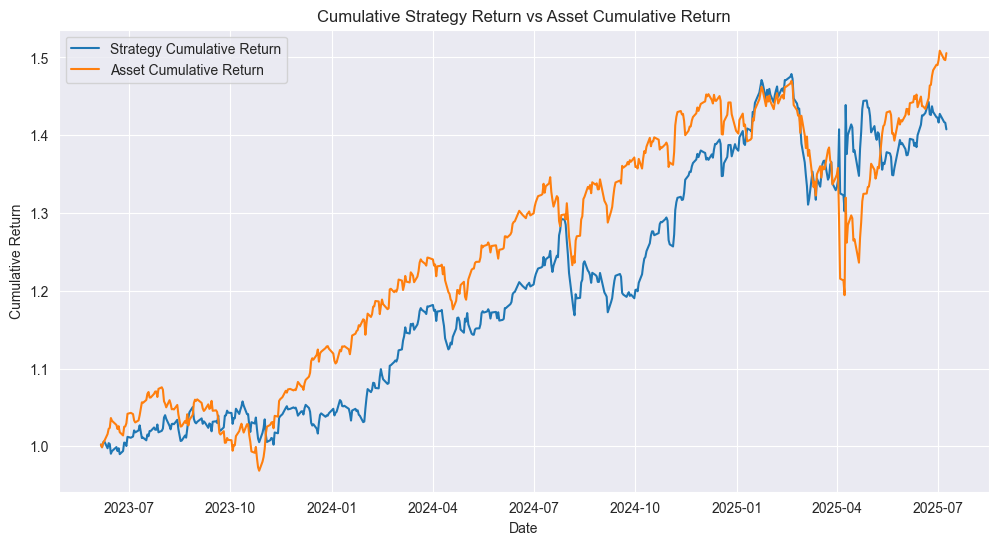

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data['Date'], data['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Reuse of the trained rbf svm model based on SPY and implement it on TSLA

In [31]:
data = fetch_data('TSLA', '2015-01-01', '2025-07-12')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, data = return_data_daily_return(data, target_type='Target_Sign', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_838/1762355872.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [32]:
y_pred = rbf_svm(X)
test_acc = binary_accuracy(y_pred, Y)
print("Test Accuracy:", test_acc)

Test Accuracy: 51.390476190476186


In [33]:
y_pred_test = rbf_svm(X_test)
split_idx = int(round(train_frac * len(data)))
test_indices = data.index[split_idx:]
data['rbf_svm_pred'] = np.nan
data.loc[test_indices, 'rbf_svm_pred'] = y_pred_test
data['rbf_svm_pred'] = data['rbf_svm_pred'].shift(1)
data.dropna(inplace=True)
print("Number of -1 predictions:", (data['rbf_svm_pred'] == -1).sum())
print("Number of 1 predictions:", (data['rbf_svm_pred'] == 1).sum())

Number of -1 predictions: 140
Number of 1 predictions: 384


In [34]:
data['strategy_return'] = data['Daily_Return'] * data['rbf_svm_pred']
data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
data['cumulative_asset'] = (1 + data['Daily_Return']).cumprod()
print("strategy return is", round(data['cumulative_strategy'].iloc[-1]-1,4)*100, "%")
print("asset return is", round(data['cumulative_asset'].iloc[-1]-1,4)*100, "%")

strategy return is 159.61 %
asset return is 35.97 %


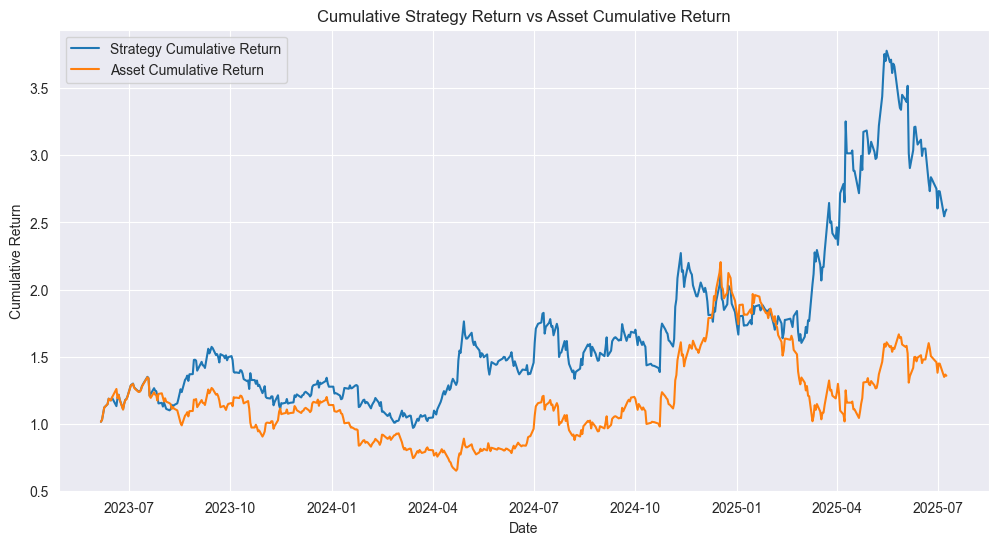

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data['Date'], data['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Logistic Regression

In [55]:
data = fetch_data('SPY', '2015-01-01', '2025-07-12')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, data = return_data_daily_return(data, target_type='Target_Sign_01', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_838/1762355872.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [53]:
w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true, class_labels=[0, 1]), 
                "loss": lambda y_pred, y_true: cross_entropy(y_pred, y_true)}
logistic_regression = LogisticRegression(w, b, optimizer)
metrics_history = logistic_regression.fit(X_train, Y_train, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

In [57]:
y_pred_test = logistic_regression(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 41.904761904761905


Trading Strategy with Logistic Regression

In [40]:
split_idx = int(round(train_frac * len(data)))
test_indices = data.index[split_idx:]
data['logistic_pred'] = np.nan
data.loc[test_indices, 'logistic_pred'] = y_pred_test
data['logistic_pred'] = data['logistic_pred'].shift(1)
data.dropna(inplace=True)
data['logistic_pred'].replace(0, -1, inplace=True)
print("Number of -1 predictions:", (data['logistic_pred'] == -1).sum())
print("Number of 1 predictions:", (data['logistic_pred'] == 1).sum())

Number of -1 predictions: 17
Number of 1 predictions: 507


/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_838/3849291231.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['logistic_pred'].replace(0, -1, inplace=True)


In [41]:
data['strategy_return'] = data['Daily_Return'] * data['logistic_pred']
data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
data['cumulative_asset'] = (1 + data['Daily_Return']).cumprod()
print("strategy return is", round(data['cumulative_strategy'].iloc[-1]-1,4)*100, "%")
print("asset return is", round(data['cumulative_asset'].iloc[-1]-1,4)*100, "%")

strategy return is 42.64 %
asset return is 50.56 %


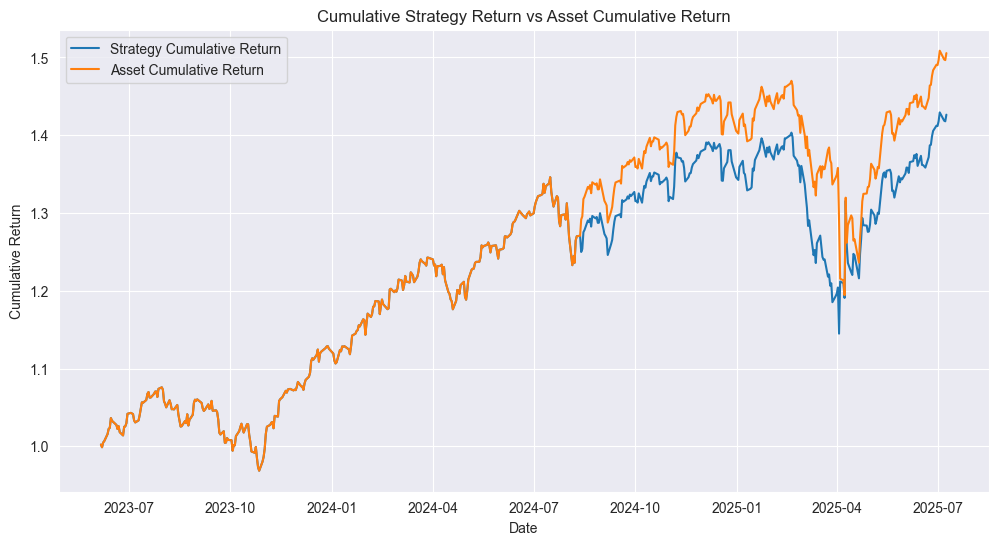

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data['Date'], data['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Reuse of the trained Logistic model based on SPY and implement it on TSLA

In [43]:
data = fetch_data('TSLA', '2015-01-01', '2025-07-12')
train_frac = 0.8
X, Y, X_train, Y_train, X_test, Y_test, data = return_data_daily_return(data, target_type='Target_Sign', train_frac=train_frac, features='whole')
X = standardize(X)
X_train = standardize(X_train)
X_test = standardize(X_test)

/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_838/1762355872.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [44]:
y_pred = logistic_regression(X)
test_acc = binary_accuracy(y_pred, Y, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 49.523809523809526


In [45]:
y_pred_test = logistic_regression(X_test)
split_idx = int(round(train_frac * len(data)))
test_indices = data.index[split_idx:]
data['logistic_pred'] = np.nan
data.loc[test_indices, 'logistic_pred'] = y_pred_test
data['logistic_pred'] = data['logistic_pred'].shift(1)
data.dropna(inplace=True)
data['logistic_pred'].replace(0, -1, inplace=True)
print("Number of -1 predictions:", (data['logistic_pred'] == -1).sum())
print("Number of 1 predictions:", (data['logistic_pred'] == 1).sum())

Number of -1 predictions: 20
Number of 1 predictions: 504


/var/folders/pz/bkvmpwns7mgcx9s_bqb2lbyc0000gn/T/ipykernel_838/766852883.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['logistic_pred'].replace(0, -1, inplace=True)


In [46]:
data['strategy_return'] = data['Daily_Return'] * data['logistic_pred']
data['cumulative_strategy'] = (1 + data['strategy_return']).cumprod()
data['cumulative_asset'] = (1 + data['Daily_Return']).cumprod()
print("strategy return is", round(data['cumulative_strategy'].iloc[-1]-1,4)*100, "%")
print("asset return is", round(data['cumulative_asset'].iloc[-1]-1,4)*100, "%")

strategy return is 12.15 %
asset return is 35.97 %


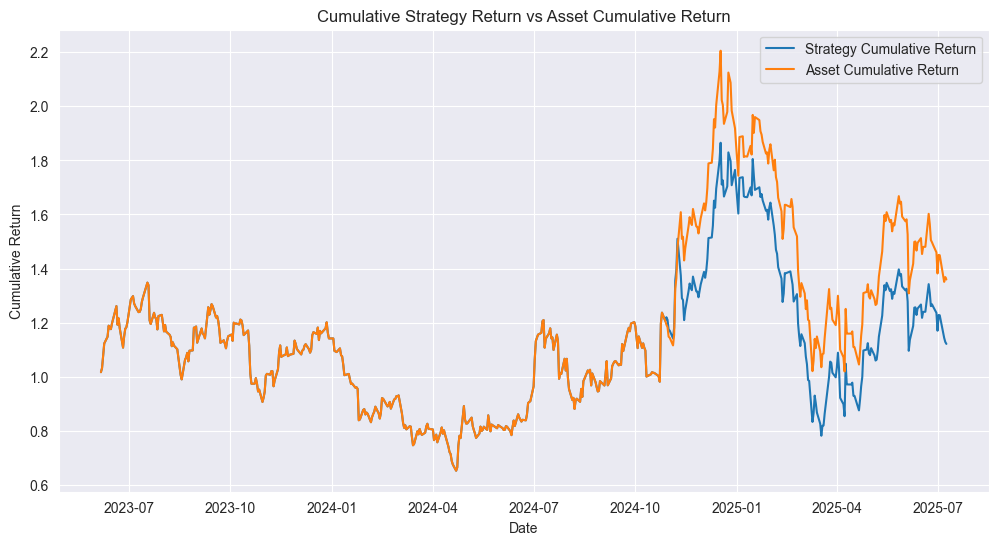

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['cumulative_strategy'], label='Strategy Cumulative Return')
plt.plot(data['Date'], data['cumulative_asset'], label='Asset Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Strategy Return vs Asset Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()